In [1]:
import numpy as np
import pandas as pd
import pertpy
import scanpy as sc
from rdkit import Chem

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

In [2]:
print(pertpy.__version__)

0.7.0


In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex"

In [4]:
adata = pertpy.data.combosciplex()

In [5]:
adata

AnnData object with n_obs × n_vars = 63378 × 27518
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
SRT3025+Cediranib            3016
Givinostat+Cediranib         2783
control+SRT2104              2756
Givinostat+Curcumin          2736
Givinostat+Sorafenib         2734
Givinostat+Carmofur          2692
Givinostat+Crizotinib        2662
Givinostat+Dasatinib         2421
Givinostat+SRT2104           2353
control+Dasatinib            2343
Givinostat+SRT1720           2260
Panobinostat+Curcumin        2244
Cediranib+PCI-34051          2161
Panobinostat+Sorafenib       2013
Panobinostat+SRT2104         1971
Panobinostat+Dasatinib       1955
Dacinostat+Danusertib        1939
Panobinostat+SRT3025         1889
control+Dacinostat           1869
Panobinostat+SRT1720         1826
Panobinostat+PCI-34051       1814
control+Givinostat           1682
Panobinostat+Crizotinib      1641
control+Panobinostat         1578
control+control              1451
Givinostat+Tanespimycin      1310
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
cont

In [7]:
adata.obs["Drug2"].value_counts()

Drug2
Dasatinib       7950
PCI-34051       7273
SRT2104         7080
Cediranib       5799
Curcumin        4980
Sorafenib       4747
Crizotinib      4303
SRT1720         4086
Carmofur        2692
Alvespimycin    2274
Danusertib      1939
SRT3025         1889
Dacinostat      1869
Givinostat      1682
Panobinostat    1578
control         1451
Tanespimycin    1310
Pirarubicin      476
Name: count, dtype: int64

In [8]:
adata.obs["Drug1"].value_counts()

Drug1
Givinostat      21951
Panobinostat    16349
control         12437
Dacinostat       6468
SRT3025          3016
Cediranib        2161
SRT2104           520
Alvespimycin      476
Name: count, dtype: int64

In [9]:
adata.layers["counts"][0].data.max()

183.0

In [10]:
adata.X = adata.layers["counts"]

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [13]:
adata = adata[:, adata.var["highly_variable"] == True]

In [14]:
adata.obs["condition"] = adata.obs.apply(
    lambda x: "control" if x["condition"] == "control+control" else x["condition"], axis=1
)

/tmp/ipykernel_3420958/3534986501.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["condition"] = adata.obs.apply(lambda x: "control" if x["condition"]=="control+control" else x["condition"], axis=1)


In [15]:
def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    n_genes=50,
    rankby_abs=True,
    key_added="rank_genes_groups_cov",
    return_dict=False,
):
    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        # name of the control group in the groupby obs column
        control_group_cov = control_group  # "_".join([cov_cat, control_group])
        # subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate] == cov_cat]
        # compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes,
            use_raw=False,
        )
        # add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()
    adata.uns[key_added] = gene_dict
    if return_dict:
        return gene_dict


def get_DE_genes(adata):
    adata.obs.loc[:, "control"] = adata.obs.condition.apply(lambda x: 1 if x == "control" else 0)
    adata.obs = adata.obs.astype("category")
    rank_genes_groups_by_cov(
        adata,
        groupby="condition",
        covariate="cell_type",
        control_group="control",
        n_genes=50,
        key_added="rank_genes_groups_cov_all",
    )
    return adata

In [16]:
adata = get_DE_genes(adata)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [17]:
assert "rank_genes_groups_cov_all" in adata.uns.keys()

In [18]:
adata.obs["cell_line"] = adata.obs["cell_type"]

In [19]:
set(adata.obs["Drug1"].unique()) - set(adata.obs["Drug2"].unique())

set()

In [20]:
adata_dummy = adata[adata.obs_names.isin(adata.obs.drop_duplicates(subset=["Drug2"]).index)]

In [21]:
list(adata.obs["Drug2"].unique())

['Panobinostat',
 'PCI-34051',
 'SRT1720',
 'SRT3025',
 'Dacinostat',
 'Sorafenib',
 'Cediranib',
 'Givinostat',
 'Danusertib',
 'Dasatinib',
 'Tanespimycin',
 'Carmofur',
 'SRT2104',
 'Crizotinib',
 'Pirarubicin',
 'control',
 'Alvespimycin',
 'Curcumin']

In [22]:
# taken from pubchem
drug_to_smiles = {
    "Panobinostat": "CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO",
    "PCI-34051": "COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO",
    "SRT1720": "C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C5=NC6=CC=CC=C6N=C5",
    "SRT3025": "COCCCC1=C(N=C(S1)C2=CC=CC=C2)C(=O)NC3=CC=CC=C3C4=NC5=C(S4)N=CC(=C5)CN6CCCC6",
    "Dacinostat": "C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=C/C(=O)NO",
    "Sorafenib": "CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC(=C(C=C3)Cl)C(F)(F)F",
    "Cediranib": "CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)OC)OCCCN5CCCC5",
    "Givinostat": "CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C(C=C3)C(=O)NO",
    "Danusertib": "CN1CCN(CC1)C2=CC=C(C=C2)C(=O)NC3=NNC4=C3CN(C4)C(=O)[C@@H](C5=CC=CC=C5)OC",
    "Dasatinib": "CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(=N3)C)N4CCN(CC4)CCO",
    "Tanespimycin": r"C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCC=C)/C)OC)OC(=O)N)\C)C)O)OC",
    "Carmofur": "CCCCCCNC(=O)N1C=C(C(=O)NC1=O)F",
    "SRT2104": "CC1=C(SC(=N1)C2=CN=CC=C2)C(=O)NC3=CC=CC=C3C4=CN5C(=CSC5=N4)CN6CCOCC6",
    "Crizotinib": "C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N=C3)C4CCNCC4)N",
    "Pirarubicin": "C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O[C@@H]6CCCCO6",
    "Alvespimycin": r"C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCCN(C)C)/C)OC)OC(=O)N)\C)C)O)OC",
    "Curcumin": "COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(C=C2)O)OC)O",
    "control": None,
}

<>:12: SyntaxWarning: invalid escape sequence '\C'
<>:17: SyntaxWarning: invalid escape sequence '\C'
<>:12: SyntaxWarning: invalid escape sequence '\C'
<>:17: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipykernel_3420958/503292394.py:12: SyntaxWarning: invalid escape sequence '\C'
  'Tanespimycin': "C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCC=C)/C)OC)OC(=O)N)\C)C)O)OC",
/tmp/ipykernel_3420958/503292394.py:17: SyntaxWarning: invalid escape sequence '\C'
  "Alvespimycin": "C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCCN(C)C)/C)OC)OC(=O)N)\C)C)O)OC",


In [23]:
adata.obs["smiles_drug_1"] = adata.obs["Drug1"].map(drug_to_smiles)
adata.obs["smiles_drug_2"] = adata.obs["Drug2"].map(drug_to_smiles)

In [24]:
from rdkit.Chem import AllChem


def get_fp(smiles, radius=4, nBits=1024):
    m = Chem.MolFromSmiles(smiles, sanitize=False)
    if m is None:
        return "invalid"
    else:
        try:
            Chem.SanitizeMol(m)
        except:
            return "invalid"
    return AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits)

In [25]:
drug_to_fp = {}
for drug, sm in drug_to_smiles.items():
    if not isinstance(sm, str):
        continue
    drug_to_fp[drug] = np.array(list(get_fp(sm)))

In [26]:
len(drug_to_fp), len(drug_to_smiles)

(17, 18)

In [27]:
features_df = pd.DataFrame.from_dict(drug_to_fp).T

In [28]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Panobinostat,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PCI-34051,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
SRT1720,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
SRT3025,0,0,1,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Dacinostat,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sorafenib,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
Cediranib,0,0,0,0,2,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
Givinostat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Danusertib,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dasatinib,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
features_cells_drug_1 = np.zeros((adata.shape[0], features_df.shape[1]))
features_cells_drug_2 = np.zeros((adata.shape[0], features_df.shape[1]))
for mol, ecfp in features_df.iterrows():
    print(mol)
    features_cells_drug_1[adata.obs["Drug1"].isin([mol])] = ecfp.values
    features_cells_drug_2[adata.obs["Drug2"].isin([mol])] = ecfp.values

Panobinostat
PCI-34051
SRT1720
SRT3025
Dacinostat
Sorafenib
Cediranib
Givinostat
Danusertib
Dasatinib
Tanespimycin
Carmofur
SRT2104
Crizotinib
Pirarubicin
Alvespimycin
Curcumin


In [30]:
adata.obsm["ecfp_drug_1"] = features_cells_drug_1
adata.obsm["ecfp_drug_2"] = features_cells_drug_2

In [31]:
adata_dummy = adata[adata.obs_names.isin(adata.obs.drop_duplicates(subset=["Drug2"]).index)]

In [32]:
adata.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
SRT3025+Cediranib            3016
Givinostat+Cediranib         2783
control+SRT2104              2756
Givinostat+Curcumin          2736
Givinostat+Sorafenib         2734
Givinostat+Carmofur          2692
Givinostat+Crizotinib        2662
Givinostat+Dasatinib         2421
Givinostat+SRT2104           2353
control+Dasatinib            2343
Givinostat+SRT1720           2260
Panobinostat+Curcumin        2244
Cediranib+PCI-34051          2161
Panobinostat+Sorafenib       2013
Panobinostat+SRT2104         1971
Panobinostat+Dasatinib       1955
Dacinostat+Danusertib        1939
Panobinostat+SRT3025         1889
control+Dacinostat           1869
Panobinostat+SRT1720         1826
Panobinostat+PCI-34051       1814
control+Givinostat           1682
Panobinostat+Crizotinib      1641
control+Panobinostat         1578
control                      1451
Givinostat+Tanespimycin      1310
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
cont

In [33]:
df_conds = adata.obs.drop_duplicates(subset=["condition"])

In [34]:
df_conds_combs = df_conds[(df_conds["Drug1"] != "control") & (df_conds["Drug2"] != "control")]

In [35]:
df_conds_combs["Drug1"].value_counts()

Drug1
Givinostat      9
Panobinostat    9
Dacinostat      3
Alvespimycin    1
Cediranib       1
SRT2104         1
SRT3025         1
control         0
Name: count, dtype: int64

In [36]:
df_conds_combs["Drug2"].value_counts()

Drug2
PCI-34051       3
Dasatinib       3
Sorafenib       2
SRT2104         2
SRT1720         2
Alvespimycin    2
Curcumin        2
Crizotinib      2
Cediranib       2
Danusertib      1
Carmofur        1
Pirarubicin     1
SRT3025         1
Tanespimycin    1
Dacinostat      0
Givinostat      0
Panobinostat    0
control         0
Name: count, dtype: int64

In [37]:
at_least_twice = (
    set(df_conds_combs["Drug1"].value_counts()[df_conds_combs["Drug1"].value_counts() >= 2].index)
    | set(df_conds_combs["Drug2"].value_counts()[df_conds_combs["Drug2"].value_counts() >= 2].index)
    | (
        set(df_conds_combs["Drug1"].value_counts()[df_conds_combs["Drug1"].value_counts() >= 1].index).intersection(
            set(df_conds_combs["Drug2"].value_counts()[df_conds_combs["Drug2"].value_counts() >= 1].index)
        )
    )
)

In [38]:
filtered_df = df_conds_combs[
    (df_conds_combs["Drug1"].isin(at_least_twice)) & (df_conds_combs["Drug2"].isin(at_least_twice))
]

In [39]:
filtered_df

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,leiden,condition,pathway1,pathway2,split,control,cell_type,cell_line,smiles_drug_1,smiles_drug_2
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_13_Lig_BC_1,sciPlex_theis,1.083277,2908,RT_13,Cediranib,PCI-34051,B1,1896,1895,2907.0,...,0,Cediranib+PCI-34051,EGFR inhibitor,HDAC inhibitor,test,0,A549,A549,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_16_Lig_BC_2,sciPlex_theis,1.298964,3487,RT_16,Givinostat,SRT1720,B4,2154,2152,3485.0,...,0,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_19_Lig_BC_11,sciPlex_theis,0.587086,1576,RT_19,Panobinostat,SRT3025,B7,1131,1129,1574.0,...,1,Panobinostat+SRT3025,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,COCCCC1=C(N=C(S1)C2=CC=CC=C2)C(=O)NC3=CC=CC=C3...
A01_A02_RT_BC_1_Lig_BC_3,sciPlex_theis,2.151281,5775,RT_1,Panobinostat,PCI-34051,A1,3139,3138,5774.0,...,1,Panobinostat+PCI-34051,HDAC inhibitor,HDAC inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_25_Lig_BC_12,sciPlex_theis,0.534188,1434,RT_25,Dacinostat,PCI-34051,C1,1015,1014,1433.0,...,1,Dacinostat+PCI-34051,HDAC inhibitor,HDAC inhibitor,train,0,A549,A549,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_28_Lig_BC_12,sciPlex_theis,1.136175,3050,RT_28,Panobinostat,Sorafenib,C4,2015,2015,3050.0,...,1,Panobinostat+Sorafenib,HDAC inhibitor,EGFR inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...
A01_A02_RT_BC_31_Lig_BC_2,sciPlex_theis,2.073798,5567,RT_31,Givinostat,Cediranib,C7,3103,3100,5564.0,...,0,Givinostat+Cediranib,HDAC inhibitor,EGFR inhibitor,ood,0,A549,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...
A01_A02_RT_BC_40_Lig_BC_18,sciPlex_theis,2.642630,7094,RT_40,Panobinostat,Dasatinib,D4,3767,3760,7087.0,...,1,Panobinostat+Dasatinib,HDAC inhibitor,EGFR inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...
A01_A02_RT_BC_49_Lig_BC_10,sciPlex_theis,2.406455,6460,RT_49,Panobinostat,SRT2104,E1,3453,3451,6458.0,...,1,Panobinostat+SRT2104,HDAC inhibitor,Sirtuin inhibitor,ood,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,CC1=C(SC(=N1)C2=CN=CC=C2)C(=O)NC3=CC=CC=C3C4=C...


In [40]:
from ott.geometry import costs, pointcloud
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

pert_effects = {}
sc.pp.pca(adata)
control = adata[adata.obs["condition"] == "control"].obsm["X_pca"]
for c in filtered_df["condition"].unique():
    if "control" in c:  # we only want to have combinations of drugs as potential OOD
        continue
    pert_effects[c] = float(
        sinkhorn_divergence(
            pointcloud.PointCloud,
            x=control,
            y=adata[adata.obs["condition"] == c].obsm["X_pca"],
            cost_fn=costs.SqEuclidean(),
            epsilon=1.0,
            scale_cost=1.0,
        ).divergence
    )

2024-04-17 13:55:56.546644: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [41]:
perts = pert_effects.keys()
vals = pert_effects.values()

In [42]:
df_effects = pd.DataFrame({"conditions": perts, "sinkhorn_div": vals})

In [43]:
df_effects_sorted = df_effects.sort_values("sinkhorn_div")

In [44]:
df_effects_sorted

,conditions,sinkhorn_div
0,Cediranib+PCI-34051,17.821072
20,SRT3025+Cediranib,18.272712
11,Givinostat+SRT2104,23.134429
18,Givinostat+Curcumin,23.330440
1,Givinostat+SRT1720,23.480160
6,Givinostat+Cediranib,24.296336
15,Givinostat+Dasatinib,24.396876
19,Givinostat+Crizotinib,24.981733
16,SRT2104+Alvespimycin,30.070134
12,Givinostat+Sorafenib,36.192255


In [45]:
k_ood_drugs = 6

In [46]:
indices = np.arange(len(df_effects_sorted))

In [47]:
len(df_effects_sorted) / k_ood_drugs

3.5

In [48]:
drugs_ood = df_effects_sorted.iloc[indices[::4]]

In [49]:
drugs_ood

,conditions,sinkhorn_div
0,Cediranib+PCI-34051,17.821072
1,Givinostat+SRT1720,23.480160
16,SRT2104+Alvespimycin,30.070134
9,Panobinostat+SRT1720,82.867790
3,Panobinostat+PCI-34051,97.108386
10,Panobinostat+Crizotinib,107.466211


In [50]:
ood_conditions = drugs_ood.conditions.values

In [51]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["condition"] in ood_conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


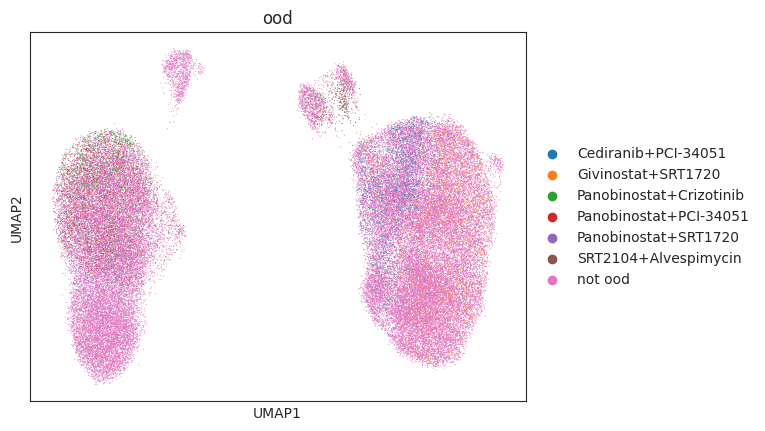

In [52]:
sc.pl.umap(adata, color="ood")

In [53]:
adata_ood = adata[adata.obs["is_ood"]]

In [54]:
ood_unique_drugs = list(adata_ood.obs["Drug1"].cat.categories)
ood_unique_drugs.extend(list(adata_ood.obs["Drug2"].cat.categories))

In [55]:
ood_unique_drugs

['Cediranib',
 'Givinostat',
 'Panobinostat',
 'SRT2104',
 'Alvespimycin',
 'Crizotinib',
 'PCI-34051',
 'SRT1720']

In [56]:
adata_remaining = adata[~adata.obs["is_ood"]]

In [57]:
remaining_unique_drugs = list(adata_remaining.obs["Drug1"].cat.categories)
remaining_unique_drugs.extend(list(adata_remaining.obs["Drug2"].cat.categories))

In [58]:
remaining_unique_drugs

['Alvespimycin',
 'Dacinostat',
 'Givinostat',
 'Panobinostat',
 'SRT3025',
 'control',
 'Alvespimycin',
 'Carmofur',
 'Cediranib',
 'Crizotinib',
 'Curcumin',
 'Dacinostat',
 'Danusertib',
 'Dasatinib',
 'Givinostat',
 'PCI-34051',
 'Panobinostat',
 'Pirarubicin',
 'SRT2104',
 'SRT3025',
 'Sorafenib',
 'Tanespimycin',
 'control']

In [59]:
set(ood_unique_drugs) - set(remaining_unique_drugs)

{'SRT1720'}

Now we need to remove one combination containing SRT1720. We remove Panobinostat+SRT1720 as we have two other combinations with Panobinostat

In [60]:
ood_conditions = set(ood_conditions) - set(["Panobinostat+SRT1720"])

In [61]:
ood_conditions

{'Cediranib+PCI-34051',
 'Givinostat+SRT1720',
 'Panobinostat+Crizotinib',
 'Panobinostat+PCI-34051',
 'SRT2104+Alvespimycin'}

In [62]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["condition"] in ood_conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

In [63]:
remaining_conditions = list(set(adata.obs["condition"].unique()) - set(ood_conditions))

In [64]:
remaining_conditions

['Givinostat+Sorafenib',
 'Panobinostat+SRT3025',
 'Panobinostat+SRT1720',
 'Givinostat+Tanespimycin',
 'Alvespimycin+Pirarubicin',
 'Panobinostat+Dasatinib',
 'Dacinostat+Danusertib',
 'Givinostat+Curcumin',
 'control+Dasatinib',
 'SRT3025+Cediranib',
 'Panobinostat+Curcumin',
 'Panobinostat+Alvespimycin',
 'Givinostat+Cediranib',
 'control+Panobinostat',
 'Givinostat+Dasatinib',
 'Panobinostat+Sorafenib',
 'Givinostat+Carmofur',
 'control+Alvespimycin',
 'Givinostat+Crizotinib',
 'control',
 'Dacinostat+PCI-34051',
 'control+Dacinostat',
 'Dacinostat+Dasatinib',
 'Givinostat+SRT2104',
 'control+Givinostat',
 'control+SRT2104',
 'Panobinostat+SRT2104']

In [65]:
adata_train = adata[~adata.obs["condition"].isin(ood_conditions)].copy()
adata_ood = adata[adata.obs["condition"].isin(ood_conditions)].copy()

In [66]:
adata_train.n_obs, adata_ood.n_obs

(54982, 8396)

In [67]:
adata_train.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
SRT3025+Cediranib            3016
Givinostat+Cediranib         2783
control+SRT2104              2756
Givinostat+Curcumin          2736
Givinostat+Sorafenib         2734
Givinostat+Carmofur          2692
Givinostat+Crizotinib        2662
Givinostat+Dasatinib         2421
Givinostat+SRT2104           2353
control+Dasatinib            2343
Panobinostat+Curcumin        2244
Panobinostat+Sorafenib       2013
Panobinostat+SRT2104         1971
Panobinostat+Dasatinib       1955
Dacinostat+Danusertib        1939
Panobinostat+SRT3025         1889
control+Dacinostat           1869
Panobinostat+SRT1720         1826
control+Givinostat           1682
control+Panobinostat         1578
control                      1451
Givinostat+Tanespimycin      1310
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
control+Alvespimycin          758
Alvespimycin+Pirarubicin      476
Name: count, dtype: int64

In [68]:
rng = np.random.default_rng(0)
split_dfs = []
for drug in adata_train.obs["condition"].unique():
    adata_subset = adata_train[(adata_train.obs["condition"] == drug)]
    n_cells = adata_subset.n_obs
    if drug == "control":
        idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["condition"]].copy()
        df["split"] = split
        split_dfs.append(df)
    elif n_cells > 300:
        idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["condition"]].copy()
        df["split"] = split
        split_dfs.append(df)

In [69]:
df_concat = pd.concat(split_dfs, axis=0)

In [70]:
len(df_concat), adata_train.n_obs

(54982, 54982)

In [71]:
df_concat[df_concat["condition"] == "control"]

,condition,split
Cell,,
A01_A02_RT_BC_58_Lig_BC_75,control,train
A01_A02_RT_BC_58_Lig_BC_87,control,train
A01_A02_RT_BC_59_Lig_BC_11,control,test
A01_A02_RT_BC_59_Lig_BC_15,control,test
A01_A02_RT_BC_60_Lig_BC_11,control,test
...,...,...
H12_A02_RT_BC_60_Lig_BC_53,control,train
H12_A02_RT_BC_60_Lig_BC_59,control,train
H12_A02_RT_BC_60_Lig_BC_79,control,train


In [72]:
df_concat["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
SRT3025+Cediranib            3016
Givinostat+Cediranib         2783
control+SRT2104              2756
Givinostat+Curcumin          2736
Givinostat+Sorafenib         2734
Givinostat+Carmofur          2692
Givinostat+Crizotinib        2662
Givinostat+Dasatinib         2421
Givinostat+SRT2104           2353
control+Dasatinib            2343
Panobinostat+Curcumin        2244
Panobinostat+Sorafenib       2013
Panobinostat+SRT2104         1971
Panobinostat+Dasatinib       1955
Dacinostat+Danusertib        1939
Panobinostat+SRT3025         1889
control+Dacinostat           1869
Panobinostat+SRT1720         1826
control+Givinostat           1682
control+Panobinostat         1578
control                      1451
Givinostat+Tanespimycin      1310
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
control+Alvespimycin          758
Alvespimycin+Pirarubicin      476
Name: count, dtype: int64

In [73]:
adata_train.obs["split"] = df_concat[["split"]]

In [74]:
adata_ood[adata_ood.obs["condition"] == "control"].n_obs

0

In [75]:
adata_ood.obs["split"] = "ood"

In [76]:
import anndata

adata_train_final = adata_train[adata_train.obs["split"] == "train"]
adata_test_final = adata_train[adata_train.obs["split"] == "test"]
adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["condition"] == "control"]))

In [77]:
adata_ood_final.obs["split"] = "ood"

In [78]:
adata_train_final.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3198
SRT3025+Cediranib            2916
Givinostat+Cediranib         2683
control+SRT2104              2656
Givinostat+Curcumin          2636
Givinostat+Sorafenib         2634
Givinostat+Carmofur          2592
Givinostat+Crizotinib        2562
Givinostat+Dasatinib         2321
Givinostat+SRT2104           2253
control+Dasatinib            2243
Panobinostat+Curcumin        2144
Panobinostat+Sorafenib       1913
Panobinostat+SRT2104         1871
Panobinostat+Dasatinib       1855
Dacinostat+Danusertib        1839
Panobinostat+SRT3025         1789
control+Dacinostat           1769
Panobinostat+SRT1720         1726
control+Givinostat           1582
control+Panobinostat         1478
Givinostat+Tanespimycin      1210
Dacinostat+Dasatinib         1131
control                       951
Panobinostat+Alvespimycin     896
control+Alvespimycin          658
Alvespimycin+Pirarubicin      376
Name: count, dtype: int64

In [79]:
adata_ood_final.obs["condition"].value_counts()

condition
Givinostat+SRT1720         2260
Cediranib+PCI-34051        2161
Panobinostat+PCI-34051     1814
Panobinostat+Crizotinib    1641
SRT2104+Alvespimycin        520
control                     500
Name: count, dtype: int64

In [80]:
adata_test_final.obs["condition"].value_counts()

condition
control                      500
Alvespimycin+Pirarubicin     100
Panobinostat+Dasatinib       100
control+Panobinostat         100
control+Givinostat           100
control+Dasatinib            100
control+Dacinostat           100
control+Alvespimycin         100
SRT3025+Cediranib            100
Panobinostat+Sorafenib       100
Panobinostat+SRT3025         100
Panobinostat+SRT2104         100
Panobinostat+SRT1720         100
Panobinostat+Curcumin        100
Dacinostat+Danusertib        100
Panobinostat+Alvespimycin    100
Givinostat+Tanespimycin      100
Givinostat+Sorafenib         100
Givinostat+SRT2104           100
Givinostat+Dasatinib         100
Givinostat+Curcumin          100
Givinostat+Crizotinib        100
Givinostat+Cediranib         100
Givinostat+Carmofur          100
Dacinostat+PCI-34051         100
Dacinostat+Dasatinib         100
control+SRT2104              100
Name: count, dtype: int64

In [81]:
adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T

/tmp/ipykernel_3420958/2775379558.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T


In [82]:
from scipy.sparse import csr_matrix

train_mean = adata_train_final.varm["X_train_mean"].T
adata_train_final.layers["centered_X"] = csr_matrix(adata_train_final.X.A - train_mean)

In [83]:
adata_train_final.layers["X_log1p"] = adata_train_final.X.copy()
adata_train_final.X = adata_train_final.layers["centered_X"]

In [84]:
sc.pp.pca(adata_train_final, zero_center=False, n_comps=30)

In [85]:
adata_train_final.obsm["X_pca"].shape

(51882, 30)

In [86]:
adata_train_final.X = adata_train_final.layers["X_log1p"]

In [87]:
adata_ood_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]
adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]

/tmp/ipykernel_3420958/3355210628.py:2: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]


In [88]:
adata_test_final.layers["centered_X"] = csr_matrix(adata_test_final.X.A - train_mean)
adata_ood_final.layers["centered_X"] = csr_matrix(adata_ood_final.X.A - train_mean)

In [89]:
adata_test_final.obsm["X_pca"] = np.matmul(adata_test_final.layers["centered_X"].A, adata_train_final.varm["PCs"])
adata_ood_final.obsm["X_pca"] = np.matmul(adata_ood_final.layers["centered_X"].A, adata_train_final.varm["PCs"])

In [90]:
adata_train.obs.apply(lambda x: x.dtype)

sample               category
Size_Factor          category
n.umi                category
RT_well              category
Drug1                category
Drug2                category
Well                 category
n_genes              category
n_genes_by_counts    category
total_counts         category
total_counts_mt      category
pct_counts_mt        category
leiden               category
condition            category
pathway1             category
pathway2             category
split                  object
control              category
cell_type            category
cell_line            category
smiles_drug_1        category
smiles_drug_2        category
ood                  category
is_ood                   bool
dtype: object

In [91]:
adata_train_final.uns.keys()

dict_keys(['Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p', 'rank_genes_groups_cov_all'])

In [92]:
adata_train_final.varm["X_train_mean"] = np.asarray(adata_train_final.varm["X_train_mean"])
adata_test_final.varm["X_train_mean"] = np.asarray(adata_test_final.varm["X_train_mean"])
adata_ood_final.varm["X_train_mean"] = np.asarray(adata_ood_final.varm["X_train_mean"])

In [93]:
import os

adata_train_final.write(os.path.join(output_dir, "adata_train_30.h5ad"))
adata_ood_final.write(os.path.join(output_dir, "adata_ood_30.h5ad"))
adata_test_final.write(os.path.join(output_dir, "adata_test_30.h5ad"))

Check that reconstruction is meaningful

In [94]:
from sklearn.metrics import r2_score


def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [95]:
decoded_test = np.matmul(adata_test_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [96]:
compute_r_squared(adata_test_final.X.A, np.asarray(decoded_test + adata_test_final.varm["X_train_mean"].T))

0.9996161316193757

In [97]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)

In [98]:
compute_r_squared(adata_ood_final.X.A, np.asarray(decoded_ood + adata_ood_final.varm["X_train_mean"].T))

0.9990839959324932